# Modeling Exoplanet Spectra
Part 2 of the [Primer on Exoplanets and JWST](https://github.com/Kappibw/JWST) series.

## Who is this tutorial for?

People that
- Have some programming know-how (basic python is fine!)
- *Don't* necessarily have an education/ experience in astronomy/astrophysics
- Are excited about JWST's potential to tell us about planets outside our solar system!

## What does this tutorial cover?

A concrete walk-through of what it takes to model exoplanet spectra, in order to compare it to observed spectra from JWST, specifically:
- Understanding the components needed to model an synthetic exoplanet
- Using PICASO, an exoplanet modeling software
- Modeling WASP-39B, the first exoplanet [JWST confirmed has CO2 in its atmosphere](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere).

## What should you know going in?

- [Part 1]() of the Primer on Exoplanets and JWST series - Retrieving Exoplanet Spectra from the James Webb Space Telescope

# 1. Set Up

## Jupyter
In order to follow along with this tutorial in place, you will need to be able to run Jupyter notebooks (install from [here](https://jupyter.org/install)). Then you can download this notebook from git and open it in Jupyter.

In [172]:
#run this cell in place once you have Juypyter up and running.
print("hello JWST!")

hello JWST!


## PICASO
Then, you'll need the python libraries used for astronomy. [PICASO](https://natashabatalha.github.io/picaso/index.html) is a python toolkit for modeling expolanet spectroscopy, and it is dependent on several other astronomy libraries, like [astropy](https://www.astropy.org/). That means just installing PICASO should give you the other packages you need.

PICASO installation instructions are [here](https://natashabatalha.github.io/picaso/installation.html). Note that part of the setup is downloading a very large (6GB) reference database.

Once you've installed PICASO, use the following to check it is set up as expected.

In [173]:
#check you have picaso
from picaso import justdoit as jdi 
from picaso import justplotit as jpi
import picaso.opacity_factory as op
import numpy as np

jpi.output_notebook()

Loading BokehJS ...

In [174]:
#double check that your reference file path has been set 
import os
refdata = os.getenv("picaso_refdata")
print(refdata)
#if you are having trouble setting this you can do it right here in the command line
#os.environ["picaso_refdata"]= add your path here AND COPY AND PASTE ABOVE 
#IT WILL NEED TO GO ABOVE YOUR PICASO IMPORT

/Users/kappi/Documents/space/PICASO/reference/


# 2. Introduction

<img src="https://drive.google.com/uc?id=1ekTkENEFgAJV5PyTw2_AQKPm-fCJizGq">

A spectrum of an exoplanet's atmosphere, like the one [NASA published of WASP-39B](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere), gives you information about what wavelengths of light were absorbed more than others by the planet you're observing.

You might be an expert and be able to see just by observation that some of the peaks correspond to say, the presence of carbon dioxide, but the spectrum will likely be much more complex than just an absorption pattern for a single molecule. Also, there are several factors that can "distort" the spectrum, such that the absorption lines may be in different locations than you'd expect from testing under lab conditions, or have different magnitudes.

These distortions can be caused by numerous phenomena, for example, doppler shift of a planet's relative motion to us can cause the absorbtion lines to shift "bluer" or "redder" than they would usually be.

### Fancy "Guess and Check"
So, looking at a raw spectrum with complex features, how do you make statements about what the planet's atmosphere is composed of? One method (that we are exploring here) is to model "synthetic" exoplanets, to the most accurate level that you can manage and compare the spectra of your synthetic planets to the one you've observed, and look for ones with the most similarities.

For example, you might compute what the spectogram of a planet with x% water and y% hydrogen in its atmosphere *would* look like and see how similar it is to the observation. 

We are going to build up a model of a synthetic exoplanet, and try to get it to match the observed WASP-39B spectrum. Hopefully, the components of our model will then tell us about the atmospheric composition of WASP-39B (even though we are cheating a bit because we already know the presence of CO2 was big news in this spectrum).

# 3. Observed Spectrum

Before we start modeling a planet to match WASP-39B, let's get hold of WASP-39B's actual observed spectrum in data format, so we can plot it next to our synthetic ones. If you did [part 1 of this tutorial](https://github.com/Kappibw/JWST/blob/main/2_retrieving_jwst_spectra.ipynb), you already downloaded the data prepared by the scientists whoe wrote [the CO2 discovery paper](https://arxiv.org/pdf/2208.11692.pdf). 

If you haven't done part 1, you can download the data from [here](https://zenodo.org/record/6959427#.Yx936-zMJqv). Download the .zip, and then look for `ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt`.

In [175]:
from astropy.io import ascii
# This will work if you are using conda and put the downloaded folder in your current env top folder. Feel
# free to change this if you used a different system.
eureka_reduction_path = os.getenv("CONDA_PREFIX") + '/ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt'
observed_data = ascii.read(eureka_reduction_path)

In [176]:
observed_data.colnames

['wavelength',
 'bin_width',
 'tr_depth',
 'tr_depth_errneg',
 'tr_depth_errpos',
 'ecl_depth',
 'ecl_depth_errneg',
 'ecl_depth_errpos']

`tr_depth` is "transit depth" which is how much light was blocked. Let's plot it.

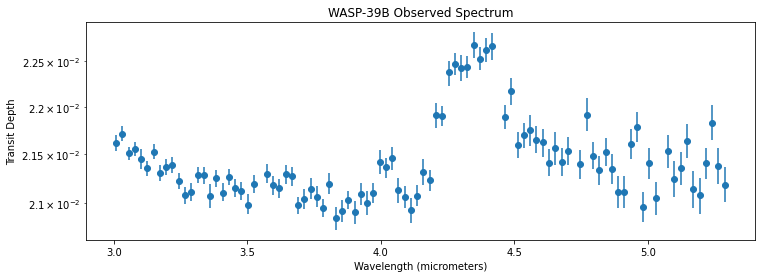

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.errorbar(observed_data['wavelength'], observed_data['tr_depth'], [observed_data['tr_depth_errneg'], observed_data['tr_depth_errpos']],fmt='o')
plt.title('WASP-39B Observed Spectrum')
plt.yscale('log')
plt.ylabel('Transit Depth')
plt.xlabel('Wavelength (micrometers)')
plt.show()

Sweet, let's pretend we just got this from the telescope and don't know what type of planet we are dealing with. We will try and produce a spectrum to match it.

# 4. Spectra Ingredients

Great, so how do we go about modeling synthetic exoplanets?

This is where tools like PICASO come in- computing what a spectogram would look like for a given atmosphere on a particular planet is not a straightforward task. You need to take into account lots of different parameters, like the mass of the planet, the presence of haze and clouds, the properties of the planet's orbit around its host star- and the characteristics of the host star itself. You also need to know the expected behaviour of different types of molecules in these alien environments. Let's go through the key components necessary.

## Molecule Light Absorbtion Data

The first thing you need to know is information about each molecule's potential effect on a planet's spectrum. We know molecules absorb light at particular wavelengths, but we gather that information through scientific experimentation- for example, directly measuring the absorption when passing light through pure gases in a laboratory-, and theoretical computation, which means we are limited in our knowledge by what we can concretely test and the errors on our theoretical predictions. 

This is further complicated by the fact that the absorbtion behaviour of molecules can change depending on their environment, so super hot planets might have different patterns to temperate ones for the same molecules. And it is extremely challenging to mimic the full range of exoplanet environments in a lab on earth. 

#### Line Lists / Opacities
When the scientific community computes, tests or updates the information we have about the behaviour of a certain molecule, they put it into "Molecular line lists", which are essentially huge databases storing the positions of the literal absorption lines you'd expect to see on a spectrum for a certain molecule, as well as other data you might need to model the behaviour of the molecule. The 6GB file you downloaded at the start of this tutorial is one such database.

Let's load up the database and have a look.

In [178]:
db_filename = os.path.join(os.getenv('picaso_refdata'), 'opacities','opacities.db')

#### CO2

Let's see if we can load up CO2, because that was the exciting discovery on WASP-39B. If we look at the [spectrum](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere) we can see that there's a clear absorbtion band between 4 and 4.5 microns, so let's have a look at that region.

In [179]:
species_to_get = ['CO2']
# We need to choose which temperature and pressure to use, because the absorption profiles of
# molecules change with changes in temp and pressure.
# We can google what the temperature is on WASP-39B
t_to_get = [1600]#kelvin
# Let's just use 1 bar, as the pressure on a planet varies according to altitude in the
# atmosphere.
p_to_get = [1] #in bars
data  = op.get_molecular(db_filename, species_to_get, t_to_get,p_to_get)

In [180]:
# Downsample the data to something reasonable to display - the raw data
# is very high fidelity.
x,y = jdi.mean_regrid(data['wavenumber'],data['CO2'][1600][1.0], R=150)

# Let's use an x_range similar to the nasa image we are looking at- 3 microns to 5.5 microns.
co2_fig = jpi.figure(height=300,y_axis_type='log',x_range=[3,5.5],y_range=[1e-25,8e-19]
                    , x_axis_label='Micron',y_axis_label='Cross Section (cm2/species)')

# We can convert wavenumber to wavelength in microns with 1e4/wavenumber
co2_fig.line(1e4/x, y,line_width=4)
jpi.show(co2_fig)

Cool! We can see that CO2 in isolation produces this tell-tale bump between 4 and 4.5 microns. We could do this with any molecule we like in the database, and examine it under conditions (temp and pressure) that we expect on an exoplanet, to get a quick view on how the molecule behaves in isolation.

PICASO will similarly use this database as an input, and it will adjust and combine the data for the different molecules on the planet it is modeling.

## Star Parameters

So now we can look up how molecules should behave under specific conditions, but in order to know what a spectrum from a planet would look like, we also need information about its host star. The light we use to make a transmission spectrum is from the planet's host star, and it travels through the atmosphere of the planet to get to us, so we need to know the properties of the star.

Let's get our information about WASP-39-b from [exo.MAST's page for the planet](https://exo.mast.stsci.edu/exomast_planet.html?planet=WASP39b).

We can get a list of the parameters we need for the PICASO functions in [the docs](https://natashabatalha.github.io/picaso/picaso.html). Ctrl-F for the <code>.star()</code> function which sets up the properties of the host star.

Some things of note for our parameters:

- We are using the default stellar database option, not the filename option. This uses the [pysynphot](https://pysynphot.readthedocs.io/en/latest/how_works.html) data set to simulate the stellar spectrum for the parameters you set up - it creates sythetic photoemtry (read: starlight) to pass through our model exoplanet's atmosphere.

- The <code>metal</code> parameter is 'metallicity' which is given as [Fe/H] in exo.MAST as it is a measure of the ratio of heavier elements (Fe) to lighter elements (H) in the star (the units are in relation to the metalicity of our sun - so a value close to 0 like this one means a similar metallicity to our sun. We are going to dive into this parameter more deeply on our exoplanet for the "Chemistry Parameters" section below.

- The <code>logg</code> option is "Logg cgs of the stellar model if using the stellar database feature." CGS is just a unit: Centimetre–gram–second, and logg is "Log g" -an expression of gravity on the surface of the star. So logg cgs is the surface gravity expressed in cgs units, which is labeled as log<sub>10</sub>(g)[cgs] in exo.MAST, and if you hover over it you can see it says "stellar surface gravity".

In [181]:
import astropy.units as u
import pandas as pd

# Open a connection to the database we read from in the previous section, 
# so that PICASO can use it as it wishes, but clip the range of wavelengths 
# to load up so it runs faster.
opacity = jdi.opannection(wave_range=[1,5])

# the .inputs() function instantiates a blank PICASO model
synthetic_wasp39b = jdi.inputs()

# Here we set a subset of params that the PICASO workshops use and should be sufficient to run our simulations.
# These values are directly taken from exo.MAST's WASP 39B page.
synthetic_wasp39b.star(opacity, temp=5400 , metal=0.01, logg=4.45, radius=0.9, radius_unit=u.Unit('R_sun') )

## Planet Parameters
We also need to give PICASO information that we know about the planet itself. 

### Gravity
TODO(kappi): Why does PICASO need to know planet gravity for these simulations?

Here we want to Ctrl-F in the [the docs](https://natashabatalha.github.io/picaso/picaso.html) for the <code>.gravity()</code> function, which informs PICASO about the gravity on the planet.

In [182]:
# PICASO really needs information about the gravity on a planet, which we can specify
# by telling it the mass and radius of the planet.

# We get these values from exo.MAST, which conveniently has them in the units we are used to!
synthetic_wasp39b.gravity(mass=0.28, mass_unit=u.Unit('M_jup'), radius=1.27, radius_unit=u.Unit('R_jup'))

### Pressure / Temperature Atmosphere Profile

PICASO also needs to know what kind of atmosphere you want to model. The most important component of this is the Temperature/Pressure profile. This just means stating how temperature varies as you go from the outer reaches of the atmosphere (low pressure) to deep within the planet's atmosphere (high pressure). The extreme options are:

- isothermal: temperature remains the same throughout the atmosphere
- greenhouse: temperature rises with the pressure, getting hotter as you descend.
- inverse greenhouse: temperature drops with pressure, getting cooler as you descend (this is a super unintuitive option to me).

I think "greenhouse" is the most intuitively straightforward, so we can start with setting up a very simple Temperature/Pressure profile where temp increases with pressure. We do this by giving PICASO a list of pressure values and their corresponding temperature values, where each entry of the list is called a "level"- mapping to an altitude "level" in the planet's atmosphere with that pressure. If you use more levels your model will be more detailed but run slower. 50-90 is reccommended.

#### Pressure
If we imagine our "levels" as equally spaced altidude bands on the planet, then we will assign pressures to each that decrease logarithmically with increased altitude, because gas is compressable and tends to behave in that way in planetary atmospheres (including earth).

In [183]:
nlevels = 50
# Logspace goes from base^(start) to base^(end)
# so here we are going from 10^-6 to 10^2, which is
# 1 microbar to 100 bars of pressure.
pressure = np.logspace(-6,2,nlevels)

#### Temperature

For our corresponding temperature values, we are going to start out with just decreasing temperature linearly as we increase levels. This is a simplification but approximates a 'greenhouse' atmosphere.

In [184]:
# We can see from exo.MAST that the equilibrium temp
# of WASP 39B is 1120 kelvin, so let's use a scale
# around that of temperatures.
min_t = 500
max_t = 2000
# We are going to linearly increase temperature even
# though our pressure is increasing on a log scale.
temperature = np.linspace(min_t,max_t,nlevels)

#### Fancier Temperature

If we want to be a bit fancier than our very simple P/T profile we set up above, we can use something called the 'double gray model', which models the change in temperature through the atmosphere to a more complex level. The equation uses a variable $\gamma$ ("gamma") that increases the closer an atmosphere is to the "greenhouse" extreme, is 0 when an atmosphere is isothermal, and tends more negative if the atmosphere is closer to inverse greenhouse. 

If you want, you can read more about the 'double gray model' in the paper [here by Guillot et al. 2010](https://arxiv.org/pdf/1006.4702.pdf), but you are welcome to just trust me that the following code produces a sensible temperature/pressure profile for us to use.

We are going to use $\gamma$ = 10, so we are guessing WASP-39b has something closer to the greenhouse scenario.

The value $\tau$ ("tau") is a measure of "optical depth" which basically tells us how opaque a material is. Here we are saying that as our atmosphere gets denser (higher pressure) we are going to increase our optical depth logarithmically- it is going to get harder for light to pass through, but not linearly harder as we increase pressure. You can read more about optical depth (I started [here](http://spiff.rit.edu/classes/phys440/lectures/optd/optd.html) and [here](http://astro.vaporia.com/start/opticaldepth.html)) if you want to know why that is a sensible choice to make.

In [185]:
# Pick gamma to give us a greenhouse style atmosphere
gamma = 10
# A scaling factor we can mess around with representing how much of the 
# star's rays get to the planet
F_sig = 1500**4
# Let's assume the optical depth logarithmically increases from 1e-5-1000
tau =np.logspace(-5,3,50)

# The fancy equation from the double gray model to get our list of temperatures 
# to match our list of pressures.
fancy_temperature = (F_sig * ((1/gamma -gamma)*np.exp(-tau/gamma) +1 + gamma)) **(0.25)


#### Setting the Atmosphere in PICASO

Now we have two options for temperature, `temperature` and `fancy_temperature`. We will start out using `temperature` and then we can come back and update our model to use `fancy_temperature` later if we want.

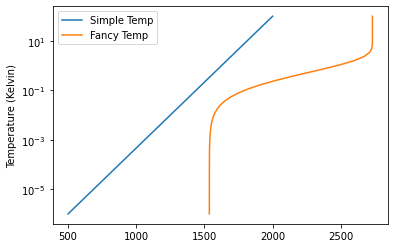

In [186]:
# Now let's add our parameterized profile
synthetic_wasp39b.atmosphere(df = pd.DataFrame({
                'pressure':pressure,
                'temperature':temperature}),verbose=False)

import matplotlib.pyplot as plt
## Let's sanity check what we have done.
plt.plot(temperature, pressure, label='Simple Temp')
plt.plot(fancy_temperature, pressure, label='Fancy Temp')
plt.legend()
plt.yscale('log')
plt.ylabel('Pressure (Bars)')
plt.ylabel('Temperature (Kelvin)')
plt.show()

### Chemistry Parameters

Our final important component is the chemistry of the planet's atmosphere- that is, which molecules are actually present. If we knew exactly which ones were there, and how much of each there were, we could force PICASO to use those directly. 

Unfortunately, since we aren't astrophyscists, we have no idea what molecules would be present. Worse, we (probably) aren't chemists either, so if we were to totally guess the molecules and their relative abundances, we'd probably pick a mixture that wouldn't even work in the physical world (our molecules would probably react with each other and not be a stable mixture).

Luckily PICASO can help us here. If we give PICASO two important parameters to work off - Metallicity and C/O ratio, it can find a mixture of molecules that would be in a stable equilibrium on the exoplanet. It does this by using an external chemistry database that was computed by a Chemistry professor called [Channon Visscher](https://www.spacescience.org/bio.php?emp=CVISSCHER). 

Let's do that and then we can grab the top 10 most abundant molecules from the suggested mixture and use those for our simplified atmosphere.

#### Metallicity

<img src="https://drive.google.com/uc?id=1XPOsOCrfzQhCzxV0NloZ_n1lZbalmV0s" width="400">

Metallicity is a measure of how many "heavier" elements are present. In astronomy "metals" are any elements heavier than hydrogen and helium, and so "metallicity" is the ratio of metals to non metals. It can be written as M/H (Metals to Hydrogen), and is often also measured more specifically by Fe/H (Iron to Hydrogen) - which you may have seen earlier in exo.MAST when we looked up the metallicity of the host star for our `.star()` inputs. Iron is partly used because it is easy to detect in spectroscopy. For our purposes the two measurements can be thought of as interchangeable.

Also of note is that planet metallicity is measured relative to solar metalicity of *our* sun. So we will input `log_mh` as our metalicity- the natural log of the planet's metallicity relative to the sun's metalicity. In other words ([Wikipedia's words](https://en.wikipedia.org/wiki/Metallicity#Chemical_abundance_ratios)), stars and planets with a higher metallicity than the Sun have a positive common logarithm, whereas those more dominated by hydrogen have a corresponding negative value. For example, stars with a [Fe/H] value of +1 have 10 times the metallicity of the Sun (10<sup>1</sup>); conversely, those with a [Fe/H] value of −1 have 1⁄10 (10<sup>-1</sup>), while those with a [Fe/H] value of 0 have the same metallicity as the Sun, and so on.

If we know the metallicity of a planet's host star, that tells us what the metallicity of the disk of material that formed the star - and its planets- approximately was. From looking at our own solar system, and observed exoplanet systems we think that:
  1) There is a relationship between the metalicity of a star and that of its planets (as they formed from the same disk of material)
  2) There is a trend of decreasing metallicity with increased mass of gas-giant planets
  
So, knowing the metallicity of WASP-39B's star, and the planet's size, we can predict the metallicity of the planet's atmosphere, using our own solar system as a guide. WASP-39B's host star has a metallicity very similar to our own Sun (we saw this above in the "Star Parameters" section) and WASP-39B has a mass similar to that of Saturn, and therefore we can predict it has a similar metallicity of **~ 10x solar**.

Interestingly, data we had from before JWST's observation didn't necessarily align with this 10x solar prediction. Measuring planet metallicity directly can be tricky, and often we use H2O abundance in exoplanet atmospheres as a proxy for it. However, the H2O we observed in WASP-39B's atmosphere implied a much higher metalicity: >100x solar. The JWST detection of CO2 was especially exciting because it fit with the 10x prediction, allowing us to explain the H2O findings via the presence of clouds (which affect things in complicated ways, as we will discuss later in this tutorial).

Let's set our metallicity to 10x solar, which will help PICASO constrain what molecules will be present (ex: it will know not to make hydrogen and helium more abundant than they are in our sun):

In [187]:
log_mh = 1 #log relative to solar, so 10^1 here = 10x solar.

#### C/O Ratio

TODO(kappi): Go over this with Natasha and find the image of the snowlines we saw.

Another important chemical ratio is that of Carbon to Oxygen in a planet's atmosphere. This is a little less straighforward than metallicity, but is exciting to astronomers because it gives us information about how a planet formed. 

At a high level, this number tells us how far from the parent star the planet intially formed (though planets can migrate in their lifetimes). This is because, in the primordial disk of material that stars and planets form from, molecules will be available in either gas or solid form depending their freezing point and on how far from the center, and therefore colder, the planet forms.

For us, this number is important because it tells us the concentrations of molecules with Oxygen in them (example: H2O) vs molecules with Carbon in them (eg: CO, CO2). 

A planet with a fixed Temp/Pressure profile and fixed metallicity could still have a big varience of molecule abundances depending on it's C/O ratio. This effect is more extreme for hot planets like WASP-39B, for example you can see here that for a temperature of 2000 kelvin, varying C/O can take you from an atmosphere dominated by water to one where water isn't even in the top 5 most abundant molecules:

_From the paper [C/O RATIO AS A DIMENSION FOR CHARACTERIZING EXOPLANETARY ATMOSPHERES](https://iopscience.iop.org/article/10.1088/0004-637X/758/1/36)_

<img src="https://drive.google.com/uc?id=1tNdEkaikY7MpL3hETomOW2S0AmfE8ba6" width="500"></img>

C/O is also given in PICASO in units relative to solar C/O, which is worth noting because you're not giving it the actual ratio of Carbon to Oxygen, but rather the ratio relative to the Solar C/O, which is ~0.5. 

In [188]:
# Let's cheat a bit, and use the fact that we know CO2 was observed on 
# WASP-39B to keep our C/O low, as we can see in the graph above that above
# a C/O of 1, CO2 drops right off.

c_o = 0.23 #relative to solar

Now we can ask PICASO to make us a mixture of molecules consistent with the Metalicity and CO we set up, and we can take a look at what it creates. We can look at the "atmosphere profile" which shows us the abundances of various molecules at different levels of our atmosphere (levels being places where temperature and pressure differ in the manner we defined above).

In [189]:
# Tell PICASO to use the Channon Visscher database to find chemistry consistent with our C/O and M/H
synthetic_wasp39b.chemeq_visscher(c_o, log_mh)

# Look at the very top levels of our planet's atmosphere
synthetic_wasp39b.inputs['atmosphere']['profile'].head()

,pressure,temperature,e-,H2,H,H+,H-,H2-,H2+,H3+,...,Cs,CO2,HCN,C2H2,C2H4,C2H6,SiO,MgH,OCS,graphite
0,0.000001,500.000000,3.676100e-30,0.828690,6.334800e-18,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,...,9.397400e-22,0.000746,2.177600e-14,3.056400e-22,5.348700e-16,2.997600e-14,4.505500e-38,4.505500e-38,2.372300e-08,4.500000e-38
1,0.000001,530.612245,1.651512e-27,0.828702,1.103646e-16,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,...,4.380378e-20,0.000508,3.445131e-14,5.122644e-22,1.048538e-16,1.223221e-15,6.730307e-36,4.505500e-38,2.494098e-08,4.500000e-38
2,0.000002,561.224490,3.290465e-25,0.829149,1.379575e-15,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,...,1.273556e-18,0.000457,7.642082e-14,1.753261e-21,5.529730e-17,1.661197e-16,4.246463e-34,4.505500e-38,3.480465e-08,4.500000e-38
3,0.000003,591.836735,3.644939e-23,0.829411,1.305866e-14,4.505500e-38,1.236811e-36,4.505500e-38,4.505500e-38,4.505500e-38,...,2.515300e-17,0.000390,1.426866e-13,4.566888e-21,2.777120e-17,2.556330e-17,5.124427e-32,6.812831e-38,4.325314e-08,4.500000e-38
4,0.000004,622.448980,2.897031e-21,0.829293,9.747030e-14,4.505500e-38,2.617041e-34,4.505500e-38,4.505500e-38,4.505500e-38,...,3.594969e-16,0.000284,1.942737e-13,6.705670e-21,9.526627e-18,3.117789e-18,1.025031e-29,1.205072e-37,4.216156e-08,4.500000e-38


### Reference Pressure

Lastly, we need to decide on a "reference pressure". If our planet was terrestrial, this would be the pressure at the surface, and therefore also the pressure corresponding to the radius of the planet. For gas giants like WASP-39B this is a bit more complicated- there is no "surface", so we need to pick a pressure that corresponds to our planet's "radius", so that PICASO can calculate gravity as a function of altitude from that level.

If we choose a lower pressure, that implies the planet is larger, which would mean it would block more of its star's light, and so our whole output spectrum (which is a measure of parent star's light blocked/absorbed - discussed in more detail below) would be shifted. We want to keep this in mind in case our output spectrum is offset a constant amount from our observed one, as adjusting the reference pressure might fix the issue.

PICASO suggests a reference pressure of 10 bar for gas giants, so we will start with that:

In [190]:
synthetic_wasp39b.approx(p_reference=10)

# 5. Simulation Time!

Now we have set up PICASO with everything it needs, and we understand the components needed to model an exoplanet, let's ask PICASO to output a transmission spectrum for WASP-39B.

## Run PICASO

We can use the <code>.spectrum</code> function to do so. 

We need to give the function a connection to the opacity database we used earlier to look up the absorption spectrum for water, as well as an instruction to create a "transmission" spectrum (as opposed to, for example, a reflection spectrum of star light bouncing off the planet when it's almost behind its star).

In [191]:
simulation_output = synthetic_wasp39b.spectrum(opacity, calculation='transmission',full_output=True)

# We are interested in 'transit_depth' per 'wavenumber', explained below. 
print('Output from spectrum function: ', simulation_output.keys())
# Don't worry about warnings if they seem to be ignoring molecules that aren't real, or that you
# don't care about.
wno, rprs2  = simulation_output['wavenumber'] , simulation_output['transit_depth']
wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)

/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Output from spectrum function:  dict_keys(['wavenumber', 'transit_depth', 'full_output'])


## First Things First
Before we look at our spectrum, lets look at a couple of rich pieces of data PICASO gives us in its output. These pop up often in the exoplanet fields so it's very worth taking the time to understand them.

#### Temp/Pressure Profile
First let's plot the temperature/pressure profile of the atmosphere. Our "simple" profile we are using should linearly increase temperature with a log increase in pressure. You can think of the plot as being a "cross section" of the atmosphere, so higher pressures closer to the center of the planet are at the bottom, and lower pressures at higher altitudes are at the top.

In [192]:
full_output = simulation_output['full_output']
# the .pt() function is specifically for pressure/temperature
# plots and defaults to a log scale on the Y axis, and adds
# the right axis labels.
jpi.show(jpi.pt(full_output,plot_width=500))

Great, just as we expected, PICASO used this linearly increasing temperature profile.

#### Mixing Ratios

Next, we are going to look at something a little more complex, called "mixing ratios". This is a graph with the same setup, where high pressure is at the bottom. It is going to show us the abundance of the different chemicals in the atmosphere at different pressures.

We will limit the function to the top 10 molecules for simplicity. Can you spot CO2??

In [193]:
jpi.show(jpi.mixing_ratio(full_output,limit=10,plot_width=500))

Note how CO2 is the ~4th most abundant molecule high up in the atmosphere, but lower down at higher pressures it's only the 10th. This is important to recognize because it has implications for what molecules we can detect on a planet.

Remember the $\tau$ "tau" variable for "optical depth" we talked about in the "Fancier Temperature" section? Well it turns out that is a very important concept in astrobiology, because it varies by molecule, which means that at a certain pressure, some molecules may be opaque while others are transparent. So, if you have a molecule that is only abundant at high pressures, and you also have a different molecule that "goes opaque" at a lower pressure than where your exciting molecule becomes abundant, you won't be able to "see" deep enough into the planet to realise that molecule is present!

That is why it's important to look at these various breakdowns of data, so that you can understand the limits of what you're seeing. You often see this refered to as "what pressures your spectrum is sensitive to", which is another way of asking how deep into the planet's atmosphere you can see, unlocking the possibility of seeing molecules that live deeper inside.

#### Contributions

That brings me to our last diagnostic plot, and this one is also very important, and also the most complicated (but don't worry, not horribly!). A "contribution" plot is used to see where the "$\tau$=1" surface is for the different molecules in the atmosphere. This just means it tells you at what pressure each molecule becomes "opaque", at each wavelength.

This is very useful, because at a glance we can see what molecules we have a hope of seeing show up in our spectrum. Say that a molecule should cause a spike in a spectrum, and it is present on our planet. If there's some other molecule present with a $\tau$=1 surface at much lower pressures in the wavelength where we hope to see our spike, we won't be able to see it.

Let's take a look at our contribution plot below:

TODO(kappi): Does the contribution function react to abundances? Like if you have something with a $\tau$=1 surface at very low pressure, but also very low abundance, will the $\tau$=1 surface drop to higher pressures, or is this a theoretical surface of a pure gas or something?

In [194]:
contribution = jdi.get_contribution(synthetic_wasp39b, opacity, at_tau=1)

wno=[]
spec=[]
labels=[]
for j in contribution[2].keys():
    x,y = jdi.mean_regrid(opacity.wno, contribution[2][j],R=100)
    if np.min(y)<5: # Bars
        wno+=[x]
        spec+=[y]
        labels +=[j]
fig = jpi.spectrum(wno,spec,plot_width=600,plot_height=350,
                   y_axis_label='Tau~1 Pressure (bars)',
                   y_axis_type='log',x_range=[1,5],
                     y_range=[1e2,1e-4],legend=labels)
jpi.show(fig)

/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Even though this is a busier plot, we can see straight away that H2O has $\tau$=1 surface that is high above the other molecules until >4 micons. That's when we see CO2 pop up, which makes sense because that is the wavelength region studied in the paper that confirmed CO2. 

If we only had a telescope capable of seeing 2-3.5 micons, we wouldn't be able to confirm CO2 because other molecules would obscure it.

It's worth noting that sometimes, there will be "windows" in the $\tau$=1 surfaces of a molecule, where the line dips and you can "see" further into high pressure zones. Those wavelength regions can be particularly interesting to glimpse deeper into the planet's atmosphere.

## Our Spectrum!
Now that we have some insight into the atmosphere PICASO created for our synthetic WASP-39B, let's finally take a look at the all-important spectrum, plotted against the real observed spectrum from JWST!

In [195]:
wno, rprs2  = simulation_output['wavenumber'] , simulation_output['transit_depth']
wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)

# Plot our synthetic spectrum.
fig = jpi.spectrum(wno, rprs2*1e6, plot_width=800, y_axis_type="log", x_range=(3.0,5.5))
# Plot the observed spectrum as well, to see how it matches up.
jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth']*1e6, fig, 
                    dy_low=observed_data['tr_depth_errneg']*1e6, dy_up=observed_data['tr_depth_errpos']*1e6)
jpi.show(fig)

Hm. The shape seems roughly right, but it seems to be offset quite dramatically from the observed data.

TODO(kappi): this is definitely wrong, ask Natasha if we can go over this concept again.

Earlier we spoke about "reference pressure". This is a lever we can use to align these two plots, because our Y axis here is a measure of how much of the parent star's light is being blocked at each wavelenght. Remember that our reference pressure sets the functional radius of the planet, so we can make the planet block less light by adjusting it.

Often astrobiologists will just normalize spectra via mean-subtraction because this offset doesn't really have meaning other than our arbitrary choice of reference pressure.

In [196]:
# This was the value that worked for me, I just guessed and checked.
# TODO(kappi): this seems.. very small. Ask Natasha if it is reasonable.
synthetic_wasp39b.approx(p_reference=0.001)

simulation_output = synthetic_wasp39b.spectrum(opacity, calculation='transmission',full_output=True)
wno, rprs2  = simulation_output['wavenumber'] , simulation_output['transit_depth']
wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)

# Plot again
fig = jpi.spectrum(wno, rprs2*1e6, plot_width=800, y_axis_type="log", x_range=(3.0,5.5))
jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth']*1e6, fig, 
                    dy_low=observed_data['tr_depth_errneg']*1e6, dy_up=observed_data['tr_depth_errpos']*1e6)
jpi.show(fig)

/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Sweet!! That looks pretty good! We have definitely matched the telltale CO2 bump, and we don't need to feel too bad about not matching the smaller bump at 4 micons, because the scientists who published [the paper](https://arxiv.org/pdf/2208.11692.pdf) whose observation data we are using still call it a "mystery feature". Because they were aiming to show the presence of CO2, they didn't worry about perfectly matching the data, but they are working on that now and so If you want to have a go adjusting spectra components and beat them to it, go ahead!

#### Shorter Wavelengths

We only have observed JWST data from 3-5.25 microns, but PICASO outputs a wider range. Let's have a look at our whole spectrum and see what it implies.

In [197]:
# Plot our whole spectrum
fig = jpi.spectrum(wno, rprs2*1e6, plot_width=800, y_axis_type="log", x_range=(1.0,5.5))
jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth']*1e6, fig, 
                    dy_low=observed_data['tr_depth_errneg']*1e6, dy_up=observed_data['tr_depth_errpos']*1e6)
jpi.show(fig)

What do you notice here? Can you compare this to the contribution plot section and take a guess at which molecule PICASO thinks will show itself up in the spectrum between 1 and 3 microns?

I think we are probably dealing with water, but lets see what we can do to convince ourselves in the next section.

# 6. Pulling some Levers

It's great that we managed to eyeball a fit to the JWST data, and convince ourselves that there is indeed CO2 on WASP-39B. But we used a lot of black-box magic, so let's pull things apart a bit and see what happens when we mess with some parameters directly.

In [198]:
# Store this as a function as we will want to use it a few times
def plot_wasp_39B(x_min=3.0, x_max=5.5, plot_observed=True, plot_contribution=True):
    simulation_output = synthetic_wasp39b.spectrum(opacity, calculation='transmission',full_output=True)
    wno, rprs2  = simulation_output['wavenumber'] , simulation_output['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)

    fig = jpi.spectrum(wno, rprs2*1e6, plot_width=800, y_axis_type="log", x_range=(x_min,x_max))
    if (plot_observed):
        jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth']*1e6, fig, 
                            dy_low=observed_data['tr_depth_errneg']*1e6, dy_up=observed_data['tr_depth_errpos']*1e6)
    jpi.show(fig)
    
    if (plot_contribution):
        contribution = jdi.get_contribution(synthetic_wasp39b, opacity, at_tau=1)

        wno=[]
        spec=[]
        labels=[]
        for j in contribution[2].keys():
            x,y = jdi.mean_regrid(opacity.wno, contribution[2][j],R=100)
            if np.min(y)<5: # Bars
                wno+=[x]
                spec+=[y]
                labels +=[j]
        fig = jpi.spectrum(wno,spec,plot_width=600,plot_height=350,
                           y_axis_label='Tau~1 Pressure (bars)',
                           y_axis_type='log',x_range=[1,5],
                             y_range=[1e2,1e-4],legend=labels)
        jpi.show(fig)

## Upacking Chemistry

First, let's look at the chemistry magic we used, by supplying PICASO with C/O, metallicity and a P/T profile and getting back a mixture of molecules that would exist in a stable configuration under those conditions. 

Let's pull out the most abundant molecules from that mixture and seed a new atmosphere by hand, with just those:

In [199]:
relevant_molecules=[]

abundances = synthetic_wasp39b.inputs['atmosphere']['profile']
abundances = abundances.drop(['pressure', 'temperature'], axis=1)

# Because our fancy atmosphere mix was split by the 50 levels we
# set it up with, let's take the median abundance for each molecule
# across the levels and use that.
median_top_10 = abundances.median().sort_values(ascending=False)[0:10]
print(median_top_10)

H2     0.828977
He     0.161860
H2O    0.005834
CO     0.002300
N2     0.000684
H2S    0.000268
Na     0.000035
CO2    0.000010
H      0.000004
K      0.000002
dtype: float64


Let's put these into a hand-made atmosphere object now.

In [200]:
# We can use the same pressure and temperature profiles
# we used for the simulation.
manual_atmosphere = {
    'pressure':pressure,
    'temperature':temperature,
    'H2':0.828977,
    'He':0.161860,
    'H2O':0.005834,
    'CO':0.002300,
    'N2':0.000684,
    'H2S':0.000268,
    'Na':0.000035,
    'CO2':0.000010,
    'H':0.000004,
    'K':0.000002
}

Now let's replace our fancy magic atmosphere with this handmade one, and resimulate our spectrum.

In [201]:
synthetic_wasp39b.atmosphere(df = pd.DataFrame(manual_atmosphere))
plot_wasp_39B(plot_contribution=False)

Ok, not terrible, but probably using the median values hurt CO2 here, which if we go back and look at our mixing ratio plot, has higher abundance at lower pressures, which is more what we will be seeing in a spectrum. Let's increase our CO2 by 10x and see:

In [202]:
synthetic_wasp39b.inputs['atmosphere']['profile']['CO2'] = 0.000100
plot_wasp_39B(plot_contribution=False)

Not quite as nice a fit as the magic chemistry, but we can still do a decent job of matching the data even with such a simple approximation of molecules in the atmosphere (note that here we didn't vary the abundances by pressure/temperature, so this is a simplification).

#### What about water?

Let's look at the assumed watery side of our spectrum now:

In [203]:
plot_wasp_39B(x_min=1, plot_contribution=False)

Let's bring the abundance of H20 right down and see what happens to the features at 1.5, 2 and 3 microns.

In [204]:
synthetic_wasp39b.inputs['atmosphere']['profile']['H2O'] = 0.000001
plot_wasp_39B(x_min=1)

We are absorbing far less host star light, as expected, and now we have a big dip at 3.25. 

If now look at our new contribution plot, this might suggest:
  - We are now seeing the shorter wavelength features for CO2
  - For the first time we are seeing H2S, which tracks water until 3 microns and then has the drop off that water doesn't.
  - The Tau~1 surface for water has dropped down below many other molecules, so even though it's still present on the planet, we likely couldn't detect it with this abundance.
  
Cool! Feel free to play around with the chemistry yourself and pull out contribution plots to intepret how your spectrum changes.

## Trying Fancier P/T

Let's put our atmosphere back to the fancy one, and this time try our fancy P/T profile we made earlier.

TODO(kappi): Talk to Natasha about the ways this breaks the model- we could correct the offset with ref pressure again, but is this a sign we need to bring in clouds? Or something else? How can we know the fancier P/T is more correct such that it justifies changing something else to keep it?

In [205]:
synthetic_wasp39b.atmosphere(df = pd.DataFrame({
                'pressure':pressure,
                'temperature':fancy_temperature}),verbose=False)

# Back to magic chemistry
synthetic_wasp39b.chemeq_visscher(c_o, log_mh)

plot_wasp_39B(x_min=1, plot_contribution=False)

/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


## Trying Different Star & Planet Params

Lastly, let's mess with some of the fundamental parameters of the planet and its star. We know this will be wrong, because the values we used were known true parameters for WASP-39B, but it is interesting to see how they affect the spectrum.

In [206]:
# Back to original set up
synthetic_wasp39b.atmosphere(df = pd.DataFrame({
                'pressure':pressure,
                'temperature':temperature}),verbose=False)
synthetic_wasp39b.chemeq_visscher(c_o, log_mh)

# Ramp up our gravity to match Jupiter
synthetic_wasp39b.gravity(mass=1.0, mass_unit=u.Unit('M_jup'), radius=1.0, radius_unit=u.Unit('R_jup'))
plot_wasp_39B(x_min=1, plot_contribution=False)

/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Wow so we are way off our observed data. Let's see what it looks like up close without the observed data.

TODO(kappi): Ask Natasha about this effect and how to interpret it.

In [207]:
plot_wasp_39B(x_min=1, plot_observed=False)

/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


/Users/kappi/miniconda3/envs/picaso/lib/python3.8/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


# 7. References / Further Reading (WIP)

TODO(kappi): Clouds - they don't seem needed here unless the P/T change needs them- ask Natasha and see if you can work in the "old" model with 100x solar metalicity and show how clouds can help us fit the new model. If that isn't what is going on, take out that part of the metallicity portion.

Metallicity reading [here](http://icc.dur.ac.uk/~tt/Lectures/Galaxies/TeX/lec/node27.html) 

For further reading on the state of creating molecular line lists, see [this paper](https://www.frontiersin.org/articles/10.3389/fspas.2021.795040/full).

Info on the old state of the world for WASP39B with high metallicity https://iopscience.iop.org/article/10.3847/1538-3881/aa9e4e

paper about how extremely hot planets don't behave in straightforward ways, including temp inversions in the atmosphere and non-uniform distribution of molecules in the atmoshpere https://iopscience.iop.org/article/10.3847/1538-4357/aadd9e Figure 11 shows seeing into different pressures 

https://arxiv.org/pdf/1209.2412.pdf explanation of CO ratio